https://blog.kjamistan.com/adversarial-learning-for-good-my-talk-at-34c3-on-deep-learning-blindspots/

We load a pre-trained model.

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

Using TensorFlow backend.


Now we download the cat image. Source: <https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array>.

In [2]:
url = "https://d1wn0q81ehzw6k.cloudfront.net/additional/thul/media/0eaa14d11e8930f5?w=400&h=400"

In [3]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
raw_img = Image.open(BytesIO(response.content))

And transform it to a 224, 224 pixel image.

In [4]:
from skimage.transform import resize

img = np.array(raw_img.getdata()).reshape(raw_img.size[0], raw_img.size[1], 3).astype(np.float)
img = resize(img, (224, 224, 3), mode='constant')

We can plot this:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

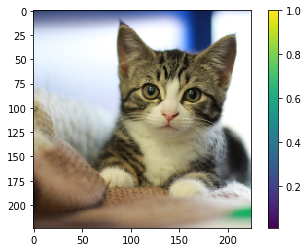

In [6]:
plt.imshow(img / 255.)
plt.colorbar()

And transform it into a format that the machine learning algorithm expects.

In [7]:
x = image.img_to_array(raw_img.copy()) # expects a PIL image
x = resize(x.astype(np.float), (224, 224, 3), mode='constant')
x = np.expand_dims(x, axis=0) # adds a new dimension at the start
x = preprocess_input(x) # preprocesses it

In [8]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123045', 'tabby', 0.72113997), ('n02123159', 'tiger_cat', 0.15921114), ('n02124075', 'Egyptian_cat', 0.096362673)]


Okay it works.

# Trying the code from the talk 

Source: <https://github.com/tensorflow/cleverhans/blob/master/cleverhans_tutorials/mnist_tutorial_keras_tf.py>.

In [25]:
import tensorflow as tf
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod
import keras.backend

sess = tf.Session()
keras.backend.set_session(sess)
x_ph = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))

# Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate(x_ph, **fgsm_params)
# Consider the attack to be constant
adv_x = tf.stop_gradient(adv_x)
preds_adv = model(adv_x)

In [26]:
from cleverhans.utils_tf import model_eval

In [27]:
x.shape

(1, 224, 224, 3)

In [28]:
preds_adv

<tf.Tensor 'resnet50_1/fc1000/Softmax:0' shape=(?, 1000) dtype=float32>

In [31]:
keras.layers.core.K.set_learning_phase(0)
tf.global_variables_initializer().run(session=sess)
sess.run(preds_adv, {x_ph:x})

InvalidArgumentError: You must feed a value for placeholder tensor 'bn_conv1/keras_learning_phase' with dtype bool
	 [[Node: bn_conv1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'bn_conv1/keras_learning_phase', defined at:
  File "/Users/kappamaki/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kappamaki/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-3cd75d6c9839>", line 6, in <module>
    model = ResNet50(weights='imagenet')
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/keras/applications/resnet50.py", line 208, in ResNet50
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/keras/layers/normalization.py", line 190, in call
    training=training)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2610, in in_train_phase
    training = learning_phase()
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 115, in learning_phase
    name='keras_learning_phase')
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kappamaki/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'bn_conv1/keras_learning_phase' with dtype bool
	 [[Node: bn_conv1/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
model_eval(sess, x, y )

In [ ]:
preds_adv.